In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.decomposition import PCA
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

thres = 0.4
G = nx.read_gml(f'nx_graph_{thres}.gml')
H = G.subgraph(max(nx.connected_components(G), key=len))
nwdf = pd.read_pickle('nwdf_full.pkl')
louvain_communities = nx.community.louvain_communities(H, resolution=1.0, seed=42)
for community_id, community in enumerate(louvain_communities):
    for node in community:
        H.nodes[node]["louvain_community"] = community_id
        nwdf.loc[nwdf['article id'] == node, "louvain_community"] = community_id

def shannon_entropy(probs):
    probs = np.asarray(probs, dtype=float)
    probs = probs[probs > 0]
    if len(probs) == 0:
        return 0.0
    return -np.sum(probs * np.log2(probs))

def category_to_main(cat_value):
    if isinstance(cat_value, list):
        return cat_value[0] if len(cat_value) > 0 else np.nan
    if pd.isna(cat_value):
        return np.nan
    return cat_value  

def compute_community_profiles_with_entropy(df):
    df = df.copy()
    if 'category' in df.columns:
        df['category_main'] = df['category'].apply(category_to_main)
    else:
        df['category_main'] = np.nan

    group_cols = ['category_main', 'country', 'continent', 'income_group']
    group_cols = [c for c in group_cols if c in df.columns]

    records = []

    for comm, sub in df.groupby('louvain_community'):
        rec = {'louvain_community': comm, 'n_nodes': len(sub)}
        for col in group_cols:
            vc = sub[col].value_counts(normalize=True, dropna=True)
            ent = shannon_entropy(vc.values)
            rec[f'{col}_entropy'] = ent
            if len(vc) > 0:
                top_label = vc.index[0]
                top_prop = vc.iloc[0]
            else:
                top_label = np.nan
                top_prop = np.nan
            rec[f'{col}_top_label'] = top_label
            rec[f'{col}_top_prop'] = top_prop
        records.append(rec)

    profiles = pd.DataFrame(records).sort_values('n_nodes', ascending=False)
    return profiles

# Heterogenitet inde i communities

def compute_within_community_variance(df):
    df['income_rank'] = df['income_group'].str.extract('(\d+)').astype(float)
    candidate_features = [
        'description_sentiment_score',
        'title_sentiment_score',
        'press_freedom_index_score',
        'press_freedom_current_rank',
        'corruption_latest_score',
        'corruption_score_slope',
        'median_age_2024',
        'gdp_per_capita_2024_international_dollars',
        'average_years_of_schooling_2023',
        'population', 'income_rank'
    ]
    features = [c for c in candidate_features if c in df.columns]

    grouped = (
        df.groupby('louvain_community')[features]
          .agg(['mean', 'std', 'var', 'count'])
    )
    return grouped

#  Emotionelle profiler pr. community

def compute_emotion_profiles_and_pca(df):
    emotion_candidates = [
        'anticipation_d','trust_d','joy_d','positive_d','surprise_d',
        'anger_d','disgust_d','negative_d','fear_d','sadness',
        'joy','positive','surprise','trust','anger','anticipation',
        'disgust','negative','fear','sadness'
    ]
    emotions = [c for c in emotion_candidates if c in df.columns]
    if not emotions:
        raise ValueError()

    community_emotions = df.groupby('louvain_community')[emotions].mean()

    return community_emotions

profiles = compute_community_profiles_with_entropy(nwdf)

within_var = compute_within_community_variance(nwdf)

community_emotions = compute_emotion_profiles_and_pca(nwdf)


<>:187: SyntaxWarning: invalid escape sequence '\d'
<>:187: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Nicolai\AppData\Local\Temp\ipykernel_8856\3878386372.py:187: SyntaxWarning: invalid escape sequence '\d'
  df['income_rank'] = df['income_group'].str.extract('(\d+)').astype(float)


,community,degree,bridge_score
node,,,
126cb79e8f8979874f2c4226092a575d,16.0,14,0.857143
4b377bc1a1717feafeff4c8940afb7e6,21.0,5,0.800000
db0d29232614873099072be2338e8fac,8.0,19,0.789474
fc4755459c6134182e2c0c5bd4bd7945,13.0,13,0.769231
484edc2fa287aebd559d15d9a854c303,29.0,13,0.769231


,comparison,nmi,ari,n_samples
0,louvain_vs_category_main,0.298273,0.173112,4446
1,louvain_vs_country,0.158524,0.028495,4446
2,louvain_vs_continent,0.103463,0.028009,4446
3,louvain_vs_income_group,0.079155,0.008809,4446


,PC1,PC2
louvain_community,,
0.0,2.620076,0.111082
1.0,-1.182807,2.209774
2.0,-0.233632,-0.168394
3.0,0.352536,0.581608
4.0,-2.825289,-0.969989


In [ ]:
within_var_reset = within_var.reset_index()
within_var_reset.columns = ['_'.join(col).strip() if col[1] else col[0] for col in within_var_reset.columns.values]
within_var_reset.rename(columns={'louvain_community_': 'louvain_community'}, inplace=True)
community_emotions_reset = community_emotions.reset_index()
community_emotions_reset.rename(columns={'louvain_community': 'louvain_community'}, inplace=True)
comm = pd.merge(profiles, within_var_reset, on='louvain_community')
comm = pd.merge(comm, community_emotions_reset, on='louvain_community')
comm = comm[comm['n_nodes'] > 50]

In [ ]:
cols = [
    'louvain_community', 'n_nodes',
    'category_main_top_label', 'category_main_top_prop',
    'continent_top_label', 'continent_top_prop',
    'income_group_top_label', 'income_rank_mean', 'income_group_top_prop',
    'median_age_2024_mean',
    'average_years_of_schooling_2023_mean',
    'gdp_per_capita_2024_international_dollars_mean'
]

nice = comm[cols].copy()

for c in ['category_main_top_prop', 'continent_top_prop', 'income_group_top_prop']:
    nice[c] = (nice[c] * 100).round(1)

nice['gdp_pc_2024_kUSD'] = (nice['gdp_per_capita_2024_international_dollars_mean'] / 1000).round(1)
nice = nice.drop(columns=['gdp_per_capita_2024_international_dollars_mean'])

nice = nice.rename(columns={
    'louvain_community': 'community',
    'n_nodes': 'N',
    'category_main_top_label': 'main_topic',
    'category_main_top_prop': 'main_topic_%',
    'continent_top_label': 'main_continent',
    'continent_top_prop': 'main_continent_%',
    'income_group_top_label': 'main_income_group', 
    'income_group_top_prop': 'main_income_group_%',
    'median_age_2024_mean': 'median_age_mean',
    'average_years_of_schooling_2023_mean': 'avg_school_years_mean',
    'gdp_pc_2024_kUSD': 'gdp_pc_2024_INTD'
})

nice = nice.sort_values('N', ascending=False)

display(nice)

# Hvis du vil have LaTeX-tabel til rapporten:
# print(nice.to_latex(index=False))


,community,N,main_topic,main_topic_%,main_continent,main_continent_%,main_income_group,income_rank_mean,main_income_group_%,median_age_mean,avg_school_years_mean,gdp_pc_2024_INTD
0,11.0,681,top,46.4,north america,44.5,1. High income: OECD,1.969925,65.7,33.245518,10.076968,35.6
1,12.0,427,sports,79.9,north america,95.8,1. High income: OECD,1.049180,98.4,38.388745,12.865508,49.6
2,8.0,391,politics,40.7,asia,45.1,4. Lower middle income,3.030769,58.2,28.045063,8.673601,19.0
3,20.0,322,sports,90.1,north america,66.8,1. High income: OECD,1.343849,88.3,37.377795,12.140580,47.9
4,22.0,316,technology,44.9,asia,38.5,1. High income: OECD,2.102649,60.9,34.772536,10.225880,37.5
5,15.0,262,sports,92.4,north america,88.5,1. High income: OECD,1.118321,95.8,38.931271,11.538615,44.4
6,5.0,231,business,77.1,north america,76.2,1. High income: OECD,1.419214,85.6,34.818043,10.335599,37.7
7,10.0,228,sports,44.7,asia,43.4,1. High income: OECD,2.504386,50.9,31.812176,9.543828,27.9
8,14.0,227,politics,33.0,north america,79.7,1. High income: OECD,1.376106,86.3,33.347058,10.062613,32.6
9,16.0,198,business,69.7,north america,66.7,1. High income: OECD,1.121827,95.9,43.149281,11.742944,51.8


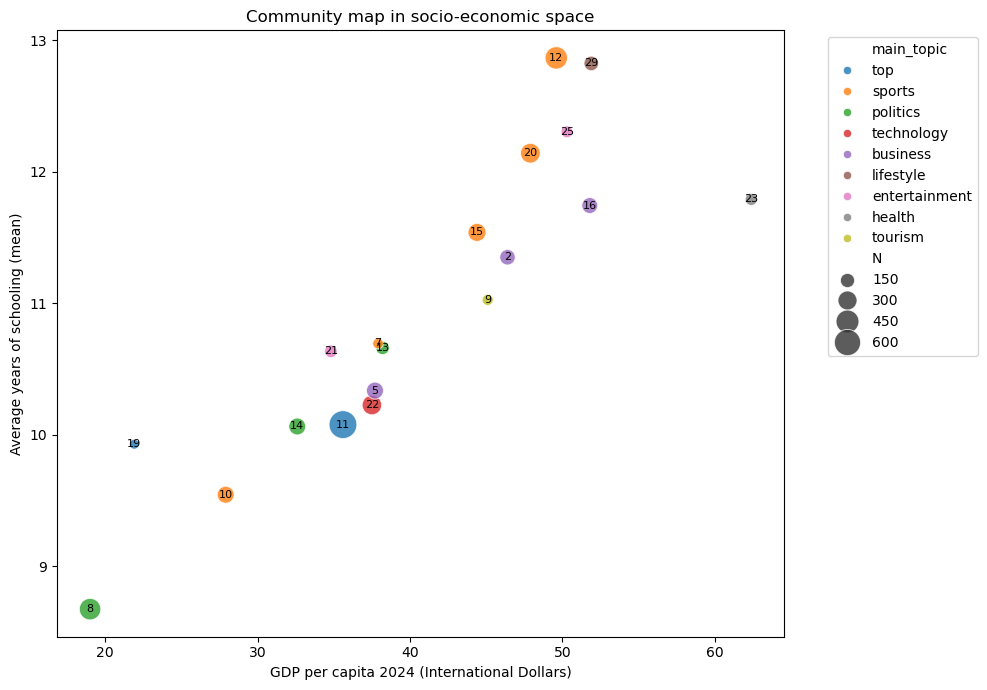

In [4]:
plot_df = nice.copy()

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=plot_df,
    x='gdp_pc_2024_INTD',
    y='avg_school_years_mean',
    hue='main_topic',
    size='N',
    sizes=(50, 400),
    alpha=0.8
)

for _, row in plot_df.iterrows():
    ax.text(
        row['gdp_pc_2024_INTD'],
        row['avg_school_years_mean'],
        int(row['community']),
        fontsize=8,
        ha='center', va='center'
    )

ax.set_xlabel('GDP per capita 2024 (International Dollars)')
ax.set_ylabel('Average years of schooling (mean)')
ax.set_title('Community map in socio-economic space')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


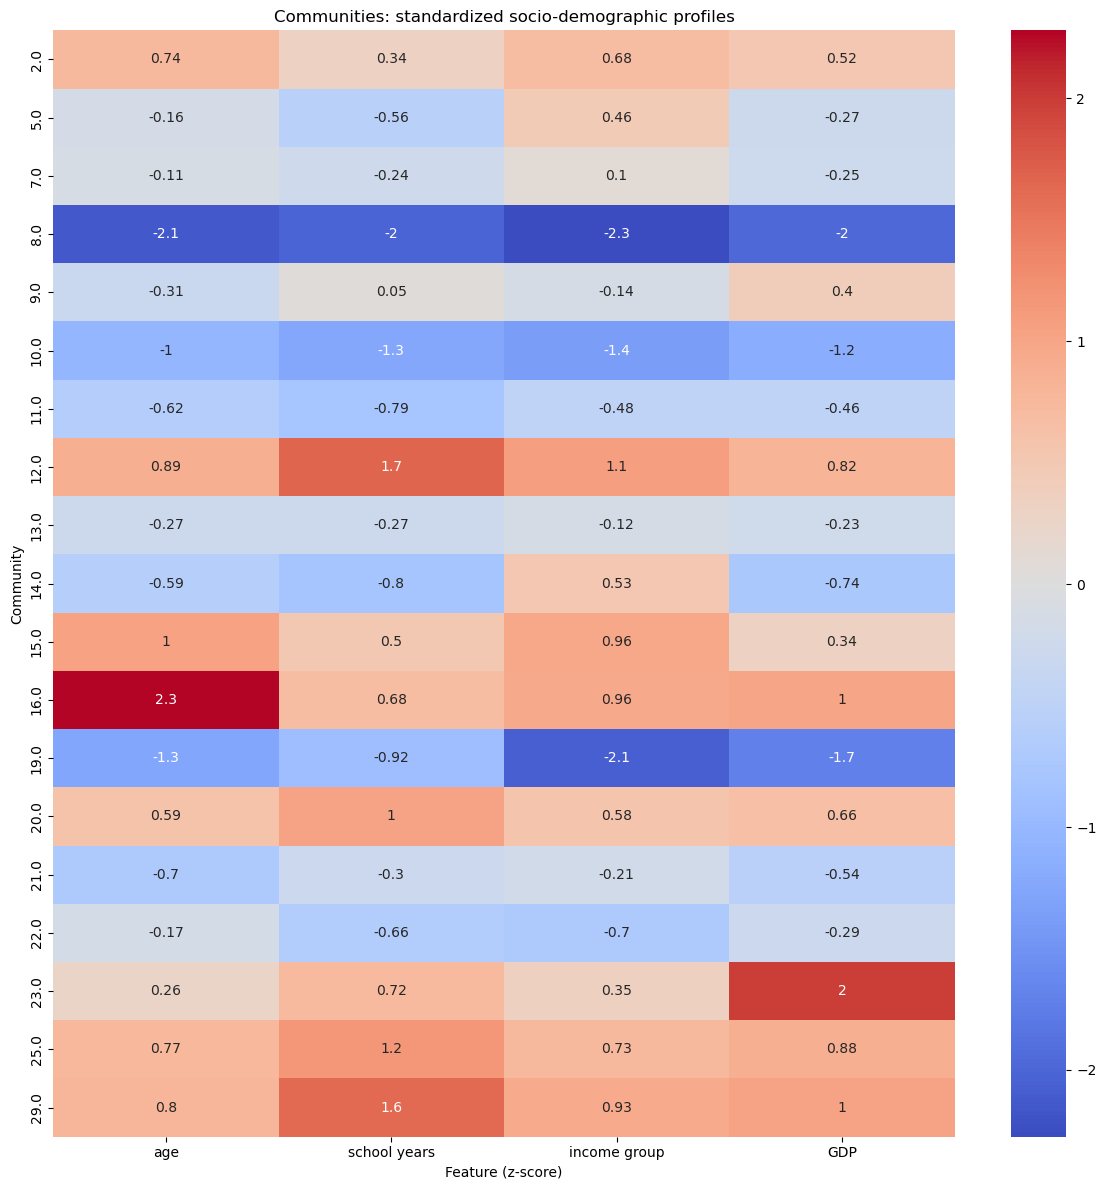

In [49]:
features = ['median_age_mean', 'avg_school_years_mean', 'negative_income_rank_mean', 'gdp_pc_2024_INTD']
nice['negative_income_rank_mean'] = -nice['income_rank_mean']
heat = nice[['community'] + features].set_index('community')

# z-score
heat_z = (heat - heat.mean()) / heat.std()

plt.figure(figsize=(12, 12))
sns.heatmap(
    heat_z.sort_index(),
    cmap='coolwarm',
    center=0,
    annot=True
)
plt.title('Communities: standardized socio-demographic profiles')
plt.ylabel('Community')
plt.xlabel('Feature (z-score)')
plt.xticks(ticks=np.arange(len(features))+0.5, labels=['age', 'school years', 'income group', 'GDP'])
plt.tight_layout()
plt.show()

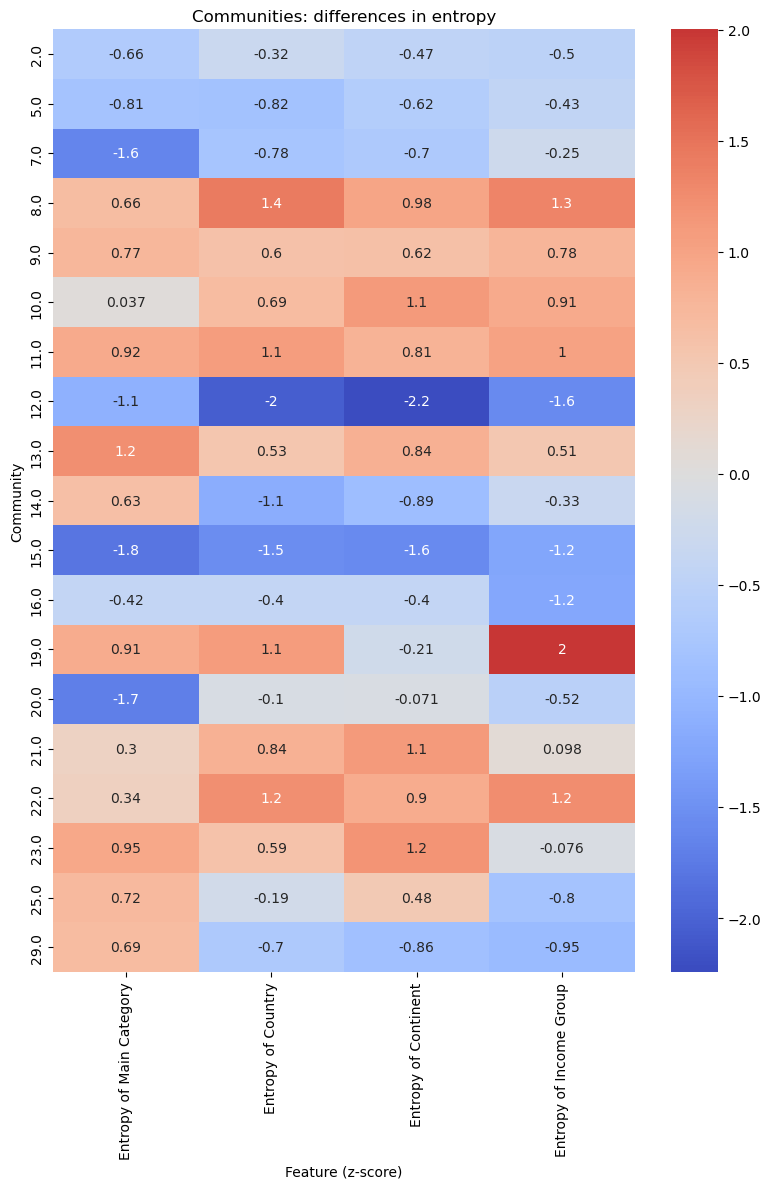

In [51]:
features_entropy = ['category_main_entropy', 'country_entropy', 'continent_entropy', 'income_group_entropy']
features_std = ['description_sentiment_score_std', 'title_sentiment_score_std', 
            'press_freedom_index_score_std', 'press_freedom_current_rank_std', 
            'corruption_latest_score_std', 'corruption_score_slope_std', 'median_age_2024_std', 
            'gdp_per_capita_2024_international_dollars_std', 'average_years_of_schooling_2023_std', 
            'population_std']

heat = comm[['louvain_community'] + features_entropy].set_index('louvain_community')

# z-score
heat_z = (heat - heat.mean()) / heat.std()

plt.figure(figsize=(8, 12))
sns.heatmap(
    heat_z.sort_index(),
    cmap='coolwarm',
    center=0,
    annot=True
)
plt.title('Communities: differences in entropy')
plt.ylabel('Community')
plt.xlabel('Feature (z-score)')
plt.xticks(ticks=np.arange(len(features_entropy))+0.5, labels=['Entropy of Main Category', 'Entropy of Country', 'Entropy of Continent', 'Entropy of Income Group'])
plt.tight_layout()
plt.show()


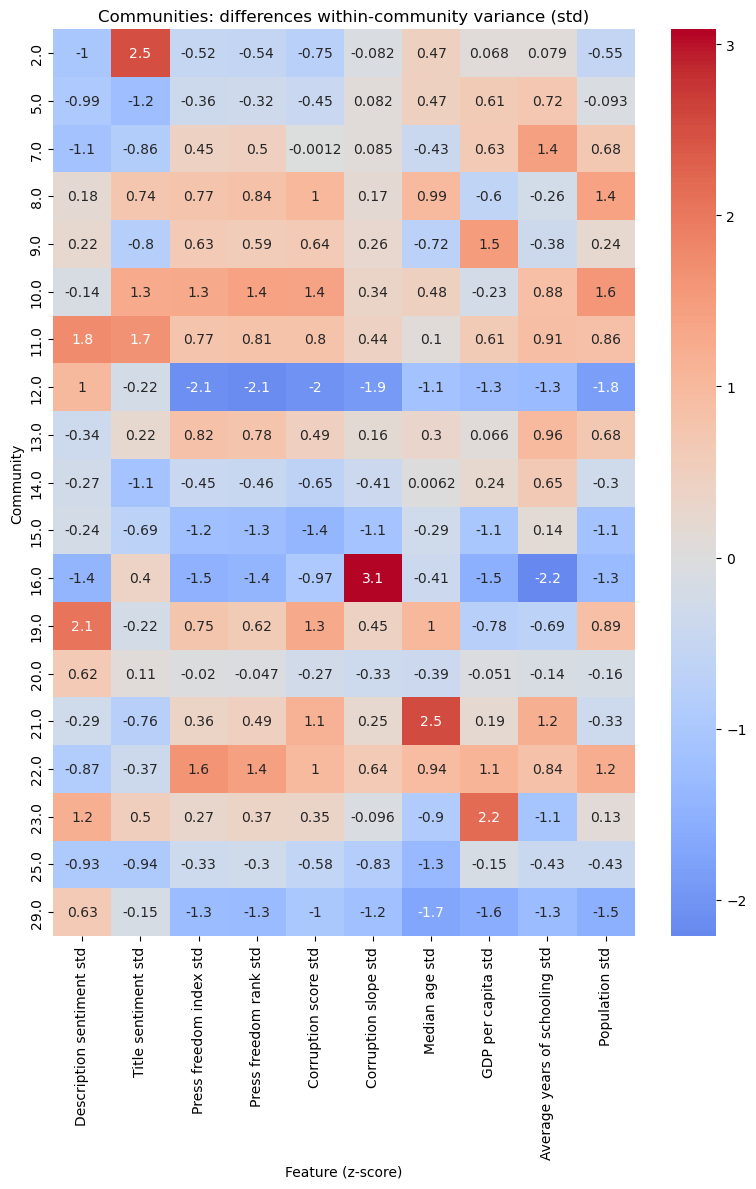

In [52]:
features_std = ['description_sentiment_score_std', 'title_sentiment_score_std', 
            'press_freedom_index_score_std', 'press_freedom_current_rank_std', 
            'corruption_latest_score_std', 'corruption_score_slope_std', 'median_age_2024_std', 
            'gdp_per_capita_2024_international_dollars_std', 'average_years_of_schooling_2023_std', 
            'population_std']
heat = comm[['louvain_community'] + features_std].set_index('louvain_community')

# z-score
heat_z = (heat - heat.mean()) / heat.std()

plt.figure(figsize=(8, 12))
sns.heatmap(
    heat_z.sort_index(),
    cmap='coolwarm',
    center=0,
    annot=True
)
plt.title('Communities: differences within-community variance (std)')
plt.ylabel('Community')
plt.xlabel('Feature (z-score)')
plt.xticks(ticks=np.arange(len(features_std))+0.5, labels=['Description sentiment std', 'Title sentiment std', 'Press freedom index std', 'Press freedom rank std', 'Corruption score std', 'Corruption slope std', 'Median age std', 'GDP per capita std', 'Average years of schooling std', 'Population std'])

plt.tight_layout()
plt.show()


Community 2 har meget stor spredning i title sentiment score

Community 3 Sports $= 90.1\%$

Community 5 Sports $= 92.4\%$

Community 6 Business $=77.1\%$

Community 7 har meget lille entropy i primære category

Community 8 har meget lavere age, school years, income group og GPD end gennemsnittet.\
Har middel høj entropy i hvilke lande og income group der er med.

Community 10, er moderat lavere age, school years, income group og GPD end gennemsnittet\
Moderat entropy i hvilke kontinenter der er med.\
Moderat stor spredning i population\
Busniess $= 73.4\%$

Community 11 er moderat spredt i hvilke lande der er med\
Moderat til stor spredning i title og description sentiment scores

Community 12 er lidt over gennemsnittet i income group, og en del mere i school years\
Moderat entropy i kategorier. Lav entropy i land, kontinent og indkomstgruppe.\
Har meget lille spredning i press freedom index score, press freedom current rant, corruption latest score, corruption score slop og population.\
Sport $=79.9\%$

Community 13 moderat høj entropy i hvilke kategorier den inkluderer

Community 14 moderat lav entropy i hvilke lande der er med

Community 15 Lav entropy i hvilke kategorier, lande, kontinenter og indkomstgrupper der er med.

Community 16 er meget over gennemsnit i age.\
Moderat lav entropy i hvilke indkomstgrupper der er med\
Har esktremt stor spredning i corruption score slope, men meget lille spredning i average years of schooling

Community 17 Sports $= 88.2\%$

Community 19 er lidt under gennemsnit i age, moderat under i GDP og meget under i income group\
Meget høj entropy i indkomstgrupper\
Stor spredning i description sentiment score

Community 20 er lidt over gennemsnit i school years\
Meget lav entropy i kategorier

Community 21 har stor spredning i median age

Community 22 har moderat stor spredning i press freedom index score

Community 23 er meget over gennemsnit i GDP\
Stor spredning i GPD

Community 25 er lidt over mean i school years

Community 29 er moderat over gennemsnit i school years.\
lille spredning i median age og GDP

In [8]:
N = H.number_of_nodes()
L = np.sum(list(dict((H.degree)).values()))/2
L_max = N * (N - 1) / 2
avg_degree = 2 * L / N
median_degree = np.median([H.degree(n) for n in H.nodes()])
mode_degree = max(set([H.degree(n) for n in H.nodes()]), key=[H.degree(n) for n in H.nodes()].count)
minimum_degree = min([H.degree(n) for n in H.nodes()])
maximum_degree = max([H.degree(n) for n in H.nodes()])
degree_sequence = sorted((d for n, d in H.degree()), reverse=True)
dmax = max(degree_sequence)
degree_variance = np.var(degree_sequence)
degree_variance
N, L, L_max, avg_degree, median_degree, mode_degree, minimum_degree, maximum_degree, degree_variance

(4446,
 np.float64(30353.0),
 9881235.0,
 np.float64(13.654071075123706),
 np.float64(7.0),
 2,
 1,
 126,
 np.float64(296.8686372725012))

- Number of nodes: $$N=4446$$
- Number of links in undirected network: $$L = \frac12 \sum^N_{i=1} k_i = \frac12 \sum^{4446}_{i=1} k_i = 30353$$
- Total number of links in a complete graph of size N: $$L_{max}=\binom{N}{2}=\frac{N(N-1)}{2}=\frac{4446(4446-1)}{2}=9881235$$
- Density: $$\frac{L}{L_{max}}=0.0031$$
- - $L \ll L_{max} \Rightarrow$ Sparse network
- Average degree for undirected network: $$\langle k \rangle = \frac{1}{N} \sum^N_{i=1} k_i = \frac{2L}{N} = \frac{2 \times 30353}{4446} = 13.65$$
- Median degree: $7$
- Mode degree: $2$
- Minimum degree: $1$
- Maximum degree: $126$
- Degree variance: $296.87$

In [ ]:
avg_shortest_path_length = nx.average_shortest_path_length(H)
print("Average shortest path length:", avg_shortest_path_length)

6.043912223522667

In [ ]:
diameter = nx.approximation.diameter(H)
avg_clustering = nx.average_clustering(H)
random = nx.fast_gnp_random_graph(N, p=avg_degree/(N-1), seed=42)
random_avg_clustering = nx.average_clustering(random)
print("Diameter:", diameter)
print("Average clustering coefficient:", avg_clustering)
print("Random graph average clustering coefficient:", random_avg_clustering)

(0.3633577776788131, 16, 0.002994478429704709)

In [ ]:
random_shortest = nx.average_shortest_path_length(random)
print("Random graph average shortest path length:", random_shortest)

3.5083280581830105

- Average shortest path length: $6.04$
- Diameter / Longest shortest path length: $18$
$$\frac{L_{real}}{L_{random}}=1.72$$
- - Average shortest path length of $6$ and diameter of $18$ is very short for a network of $4446$ nodes
- - The average shortest paths are $\approx 70\%$ longer than in a random graph

- Average clustering coefficient for graph: $C_{real}=0.36$
- Average clustering coefficient for Erdős–Rényi graph with same amount of nodes and edges: $C_{random}=0.0030$
$$\frac{C_{real}}{C_{random}}=121.34$$
- - In our network:
- - Neighbors are much more often connected with each other than expected in a random network.
- - There are lots of local clusters
- - Indicates local structures / communities

- Small-worldness: $$\sigma=\frac{\frac{C_{real}}{C_{random}}}{\frac{L_{real}}{L_{random}}}=70.55$$
- - By this definition we have a small world.

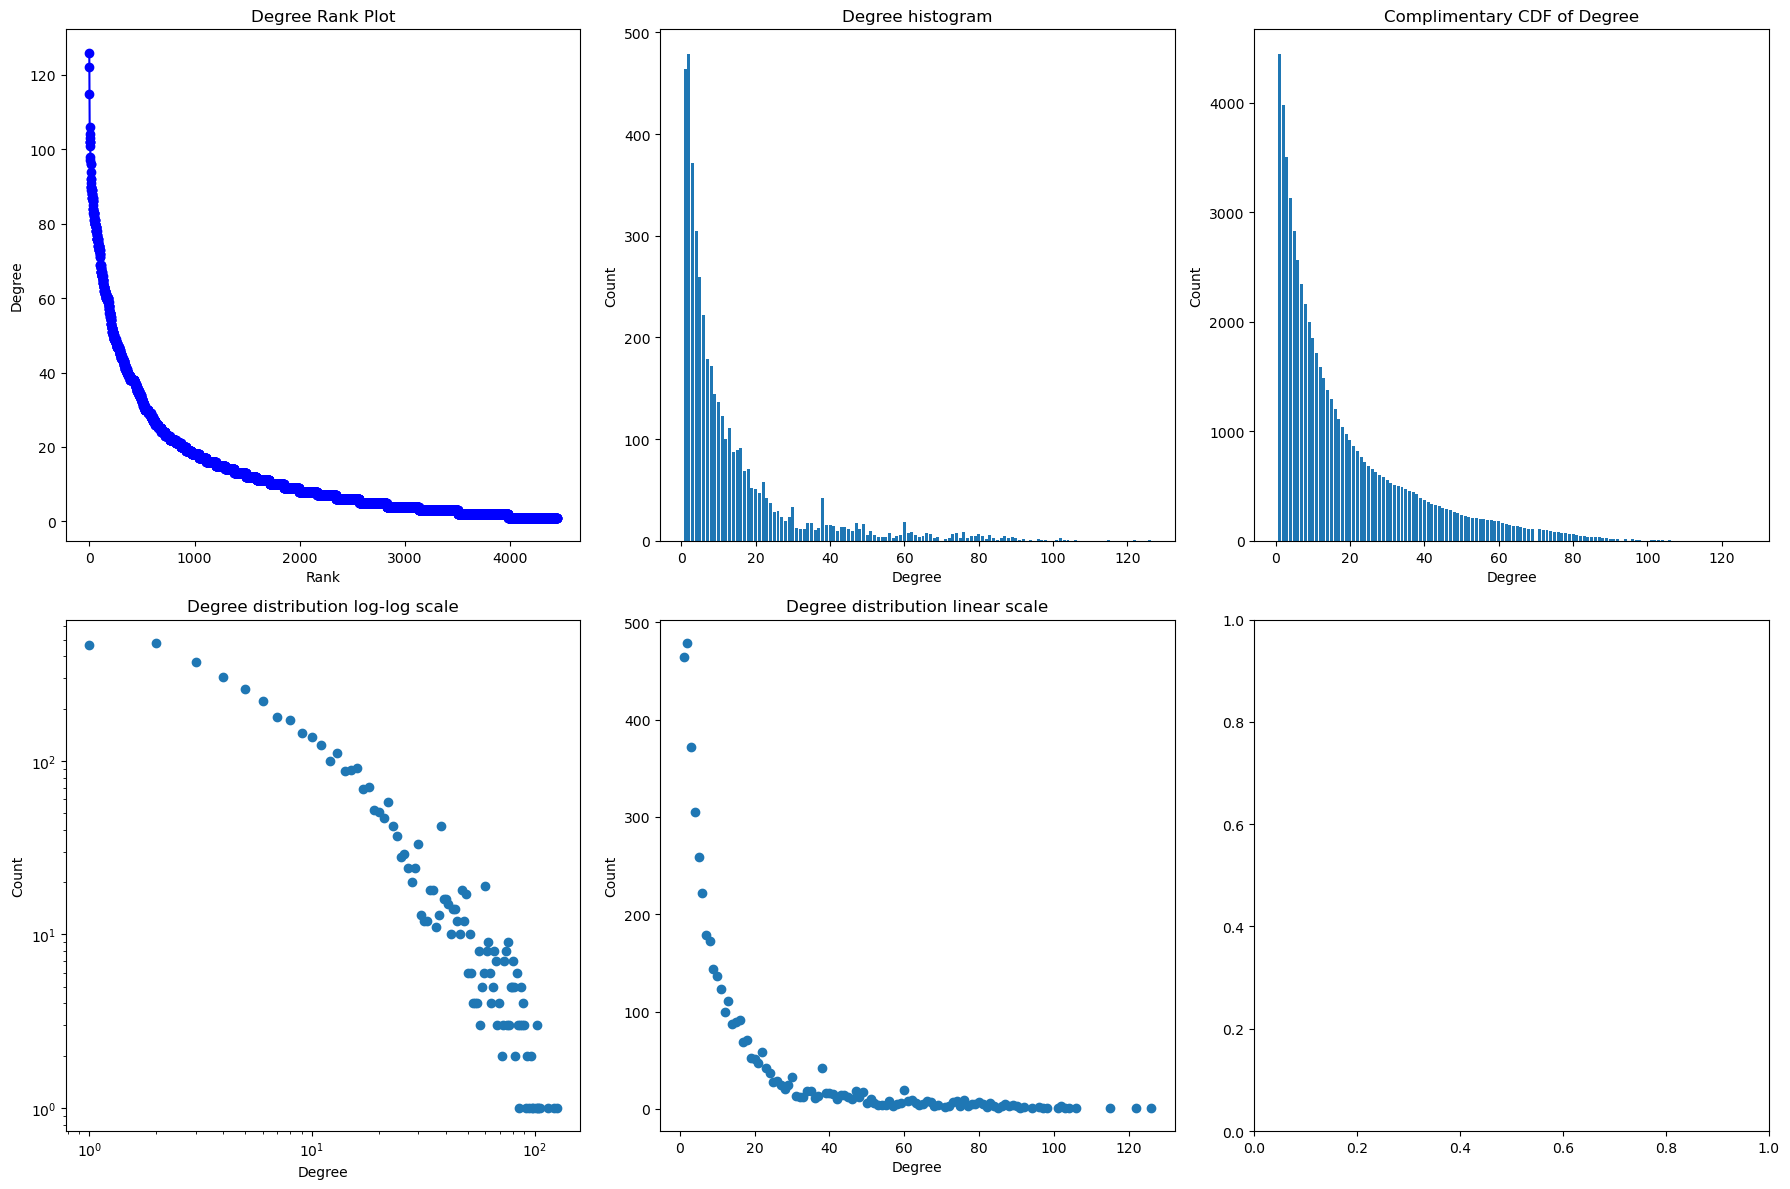

In [ ]:
from scipy import stats
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

axs[0].plot(degree_sequence, "b-", marker="o")
axs[0].set_title("Degree Rank Plot")
axs[0].set_ylabel("Degree")
axs[0].set_xlabel("Rank")

axs[1].bar(*np.unique(degree_sequence, return_counts=True))
axs[1].set_title("Degree histogram")
axs[1].set_xlabel("Degree")
axs[1].set_ylabel("Count")

degrees, counts = np.unique(degree_sequence, return_counts=True)
axs[2].bar(degrees, np.cumsum(counts[::-1])[::-1])
axs[2].set_title("Complimentary CDF of Degree")
axs[2].set_xlabel("Degree")
axs[2].set_ylabel("Count")

axs[4].scatter(*np.unique(degree_sequence, return_counts=True))
axs[4].set_title("Degree distribution linear scale")
axs[4].set_ylabel("Count")
axs[4].set_xlabel("Degree")

axs[3].scatter(*np.unique(degree_sequence, return_counts=True))
axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].set_title("Degree distribution log-log scale")
axs[3].set_ylabel("Count")
axs[3].set_xlabel("Degree")

fig.tight_layout()
plt.show()

In [ ]:
deg_centrality = list(nx.degree_centrality(H).items())
bet_centrality = list(nx.betweenness_centrality(H).items())
eigen_centrality = list(nx.eigenvector_centrality(H).items())
print("Top 3 nodes by Degree Centrality:")
print(sorted(deg_centrality, key=lambda x: x[1], reverse=True)[:3])
print("Top 3 nodes by Betweenness Centrality:")
print(sorted(bet_centrality, key=lambda x: x[1], reverse=True)[:3])
print("Top 3 nodes by Eigenvector Centrality:")
print(sorted(eigen_centrality, key=lambda x: x[1], reverse=True)[:3])

[('dd1fea69cf0523e2eb3f71dfacca08b0', 0.028346456692913385), ('b9b68eb3cec75b32c3226cd58335f2aa', 0.02744656917885264), ('c421ed5111232df8a79ce54406e926b5', 0.025871766029246342)]
[('126cb79e8f8979874f2c4226092a575d', 0.042757705403232545), ('0803ad03cd3ba3022cb8c74b065f49ee', 0.04156542685358002), ('79c08de8102932a593a2c4b7ba49b26a', 0.036060546033776515)]
[('dd1fea69cf0523e2eb3f71dfacca08b0', 0.13757994358300676), ('f0050544d21b9b899ae5821028d4b6a8', 0.12970163637720838), ('c5afdc239d594736ca3718b859e56a17', 0.12754906252302955)]


### The top 3 nodes by centrality
**1 - Score: 0.028**
- Title:
- - 'Matson (NYSE:MATX) Posts Quarterly Earnings Results, Beats Estimates By $1.86 EPS'
- Description: 
- - 'Matson (NYSE:MATX – Get Free Report) posted its quarterly earnings data on Tuesday. The shipping company reported $4.24 earnings per share for the quarter, beating the consensus estimate of $2.38 by $1.86, Zacks reports. Matson had a return on equity of 18.90% and a net margin of 14.26%. Matson Trading Down 2.1% Shares of NYSE [...]'
- Country:
- - Unites States of America
- Category:
- - Business
- Source:
- - Ticker Report

**2 Score: 0.027**
- Title:
- - 'Innovator U.S. Equity Power Buffer ETF – January (BATS:PJAN) Sets New 1-Year High – Still a Buy?'
- Description: 
- - 'Innovator U.S. Equity Power Buffer ETF – January (BATS:PJAN – Get Free Report)’s share price reached a new 52-week high during mid-day trading on Tuesday . The stock traded as high as $46.32 and last traded at $46.30, with a volume of 27366 shares traded. The stock had previously closed at $46.2350. Innovator U.S. Equity [...]'
- Country:
- - Unites States of America
- Category:
- - Business
- Source:
- - Ticker Report

**3 Score: 0.026**
- Title:
- - 'MyHealthChecked (LON:MHC) Shares Up 1.7% – Still a Buy?'
- Description: 
- - 'MyHealthChecked PLC (LON:MHC – Get Free Report) shares were up 1.7% during mid-day trading on Tuesday . The company traded as high as GBX 9.15 and last traded at GBX 9.15. Approximately 57,186 shares traded hands during trading, an increase of 33% from the average daily volume of 42,954 shares. The stock had previously closed [...]'
- Country:
- - Unites States of America
- Category:
- - Business
- Source:
- - Markets Daily

### The top 3 nodes by betweenness
**1 - Score: 0.043**
- Title:
- - 'Dancing with the Stars live results: Updated scores for Jordan Chiles and more from Episode 9'
- Description: 
- - 'The Sporting News is tracking all the competitors from Tuesday night’s show. Follow along for updates.'
- Country:
- - Unites States of America
- Category:
- - Sports
- Source:
- - Sporting News

**2 - Score: 0.042**
- Title:
- - 'CoreWeave shares slip on weak 2025 revenue forecast'
- Description: 
- - 'The company now expects 2025 revenue between US$5.1 billion and US$5.2 billion, below the US$5.3 billion consensus.'
- Country:
- - Singapore
- Category:
- - Business, Top
- Source:
- - Tech In Asia

**3 - Score: 0.036**
- Title:
- - 'This 18-Year-Old Marlins Prospect Enjoyed Standout Second Season in DSL'
- Description: 
- - 'This young Marlins catching prospect had top of the organization level production in 2025.'
- Country:
- - United States of America
- Category:
- - Sports
- Source:
- - Si

### The top 3 nodes by eigenvector
**1 - Score: 0.14**
- Same as betweenness rank 1

**2 - Score: 0.13**
- Variant of rank 1. Only description is a tiny bit different
- Title:
- - 'Matson (NYSE:MATX) Releases Quarterly Earnings Results, Beats Estimates By $0.99 EPS'
- Description: 
- - 'Matson (NYSE:MATX – Get Free Report) issued its quarterly earnings data on Tuesday. The shipping company reported $4.24 earnings per share (EPS) for the quarter, beating the consensus estimate of $3.25 by $0.99, Zacks reports. Matson had a return on equity of 18.90% and a net margin of 14.26%.The business had revenue of $880.10 million [...]'
- Country:
- - United States of America
- Category:
- - Business
- Source:
- - Ticker Report

**3 - Score: 0.13**
- Same story as rank 1 and 2, but another paper
- Title:
- - 'Matson (NYSE:MATX) Announces Quarterly Earnings Results'
- Description: 
- - 'Matson (NYSE:MATX – Get Free Report) released its quarterly earnings results on Tuesday. The shipping company reported $4.24 earnings per share (EPS) for the quarter, topping the consensus estimate of $2.38 by $1.86, Zacks reports. Matson had a net margin of 14.26% and a return on equity of 18.90%. Matson Price Performance NYSE:MATX traded down [...]'
- Country:
- - United States of America
- Category:
- - Business
- Source:
- - Watch List News

In [ ]:
import powerlaw
fit = powerlaw.Fit([H.degree(n) for n in H.nodes()]).alpha

assortativity = nx.degree_assortativity_coefficient(H)
print("Power-law exponent (alpha):", fit)
print("Degree assortativity coefficient:", assortativity)

Calculating best minimal value for power law fit
c:\Users\Nicolai\miniconda3\envs\social\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


(np.float64(9.192472307941019), 0.6389003627155662)

### The top node by degree
- Title:
- - 'Matson (NYSE:MATX) Posts Quarterly Earnings Results, Beats Estimates By $1.86 EPS'
- Description: 
- - 'Matson (NYSE:MATX – Get Free Report) posted its quarterly earnings data on Tuesday. The shipping company reported $4.24 earnings per share for the quarter, beating the consensus estimate of $2.38 by $1.86, Zacks reports. Matson had a return on equity of 18.90% and a net margin of 14.26%. Matson Trading Down 2.1% Shares of NYSE [...]'
- Country:
- - Unites States of America
- Category:
- - Business
- Source
- - Ticker Report

The network is sparse (density $0.0031$, average degree $13.65$), but shows clear small-world structure, as its average shortest path length is $6.04$ (compared to $3.5$ in a comparable Erdős–Rényi network), while the clustering coefficient is $0.36$ (compared to $0.003$ in the random network). The small-worldness measure is $\sigma\approx 70$, which indicates a very high local clustering combined with still relatively short global distances. 

The degree distribution is heterogeneous (variance $296.9$, max-degree $126$), but a power-law fit gives a unrealisticly high exponent ($\alpha \approx 9.2$), and a log-log-plot shows a clear downward curved tail. We conclude that the network is not scale-free, but rather has a wide, fast decreasing degree distribution. 

The network is strongly assortative according to degrees ($r\approx 0.64$), which indicates a close highly connected core of articles with high degrees and a periphery of low-degree nodes. The most central nodes measured but degree and eigenvector centrality are typically articles, that is in the cores, while nodes with high betweenness centrality works as bridges between different communities.

Correlation between degree and betweenness centrality: 0.5609053843400901 with p-value: 0.0
Correlation between degree and eigenvector centrality: 0.6454338189536014 with p-value: 0.0
Correlation between betweenness and eigenvector centrality: 0.29639815105679496 with p-value: 7.420070014844857e-91


Text(0.5, 1.0, 'Betweenness vs Eigenvector Centrality')

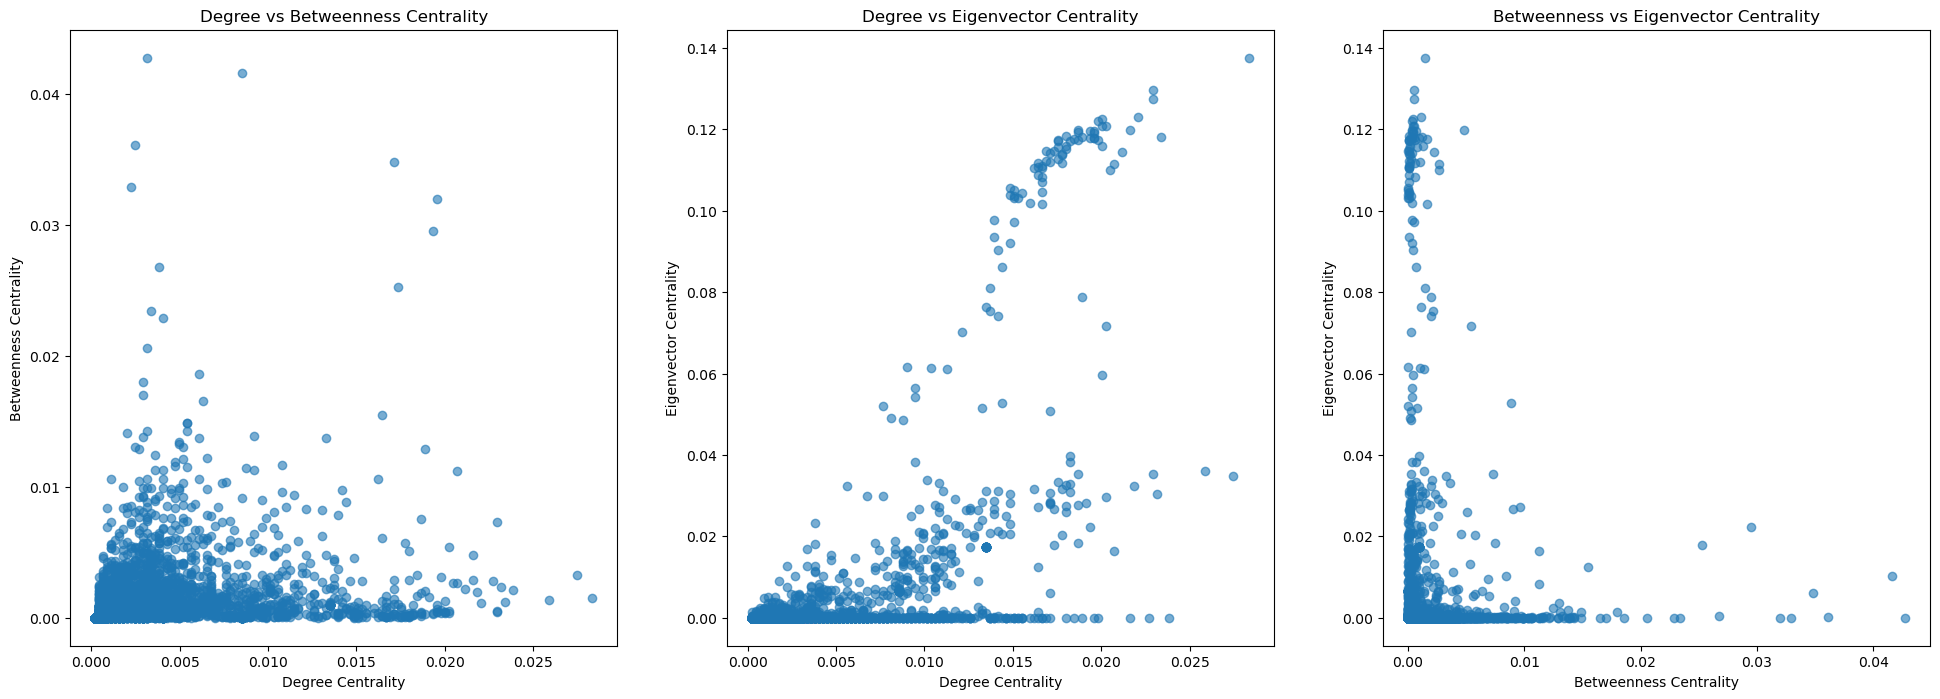

In [16]:
deg_bet = stats.spearmanr([v for k,v in deg_centrality], [v for k,v in bet_centrality])
deg_eigen = stats.spearmanr([v for k,v in deg_centrality], [v for k,v in eigen_centrality])
bet_eigen = stats.spearmanr([v for k,v in bet_centrality], [v for k,v in eigen_centrality])
print("Correlation between degree and betweenness centrality:", deg_bet[0], "with p-value:", deg_bet[1])
print("Correlation between degree and eigenvector centrality:", deg_eigen[0], "with p-value:", deg_eigen[1])
print("Correlation between betweenness and eigenvector centrality:", bet_eigen[0], "with p-value:", bet_eigen[1])

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax = ax.flatten()

ax[0].scatter(
    [dc[1] for dc in deg_centrality],
    [bc[1] for bc in bet_centrality],
    alpha=0.6
)
ax[0].set_xlabel("Degree Centrality")
ax[0].set_ylabel("Betweenness Centrality")
ax[0].set_title("Degree vs Betweenness Centrality")

ax[1].scatter(
    [dc[1] for dc in deg_centrality],
    [bc[1] for bc in eigen_centrality],
    alpha=0.6
)
ax[1].set_xlabel("Degree Centrality")
ax[1].set_ylabel("Eigenvector Centrality")
ax[1].set_title("Degree vs Eigenvector Centrality")

ax[2].scatter(
    [bc[1] for bc in bet_centrality],
    [ec[1] for ec in eigen_centrality],
    alpha=0.6
)
ax[2].set_xlabel("Betweenness Centrality")
ax[2].set_ylabel("Eigenvector Centrality")
ax[2].set_title("Betweenness vs Eigenvector Centrality")

In [17]:
import statistics

unique_data = [list(x) for x in set(tuple(x) for x in list(nwdf['category']))]
categories = []
for c in unique_data:
    for category in c:
        categories.append(category)
categories = list(set(categories))
category_deg = {category: [] for category in categories}
category_bet = {category: [] for category in categories}
category_eigen = {category: [] for category in categories}

for article, centrality in deg_centrality:
    if article in nwdf['article id'].values:
        article_categories = nwdf[nwdf['article id'] == article]['category'].values[0]
        if isinstance(article_categories, list):
            for category in article_categories:
                category_deg[category].append(centrality)
        else:
            category_deg[article_categories].append(centrality)

for article, centrality in bet_centrality:
    if article in nwdf['article id'].values:
        article_categories = nwdf[nwdf['article id'] == article]['category'].values[0]
        if isinstance(article_categories, list):
            for category in article_categories:
                category_bet[category].append(centrality)
        else:
            category_bet[article_categories].append(centrality)

for article, centrality in eigen_centrality:
    if article in nwdf['article id'].values:
        article_categories = nwdf[nwdf['article id'] == article]['category'].values[0]
        if isinstance(article_categories, list):
            for category in article_categories:
                category_eigen[category].append(centrality)
        else:
            category_eigen[article_categories].append(centrality)

category_stats = {}
for category in categories:
    deg_values = category_deg[category]
    bet_values = category_bet[category]
    eigen_values = category_eigen[category]
    if len(deg_values) > 0:
        category_stats[category] = {
            'deg_mean': statistics.mean(deg_values),
            'deg_median': statistics.median(deg_values),
            'deg_std': statistics.stdev(deg_values) if len(deg_values) > 1 else 0,
            'bet_mean': statistics.mean(bet_values) if len(bet_values) > 0 else 0,
            'bet_median': statistics.median(bet_values) if len(bet_values) > 0 else 0,
            'bet_std': statistics.stdev(bet_values) if len(bet_values) > 1 else 0,
            'eigen_mean': statistics.mean(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_median': statistics.median(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_std': statistics.stdev(eigen_values) if len(eigen_values) > 1 else 0,
        }

C:\Users\Nicolai\AppData\Local\Temp\ipykernel_8856\3262217367.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot([category_deg[category] for category in categories if len(category_deg[category]) > 0], labels=[category for category in categories if len(category_deg[category]) > 0], vert=True)
C:\Users\Nicolai\AppData\Local\Temp\ipykernel_8856\3262217367.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot([category_bet[category] for category in categories if len(category_bet[category]) > 0], labels=[category for category in categories if len(category_bet[category]) > 0], vert=True)
C:\Users\Nicolai\AppData\Local\Temp\ipykernel_8856\3262217367.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot(

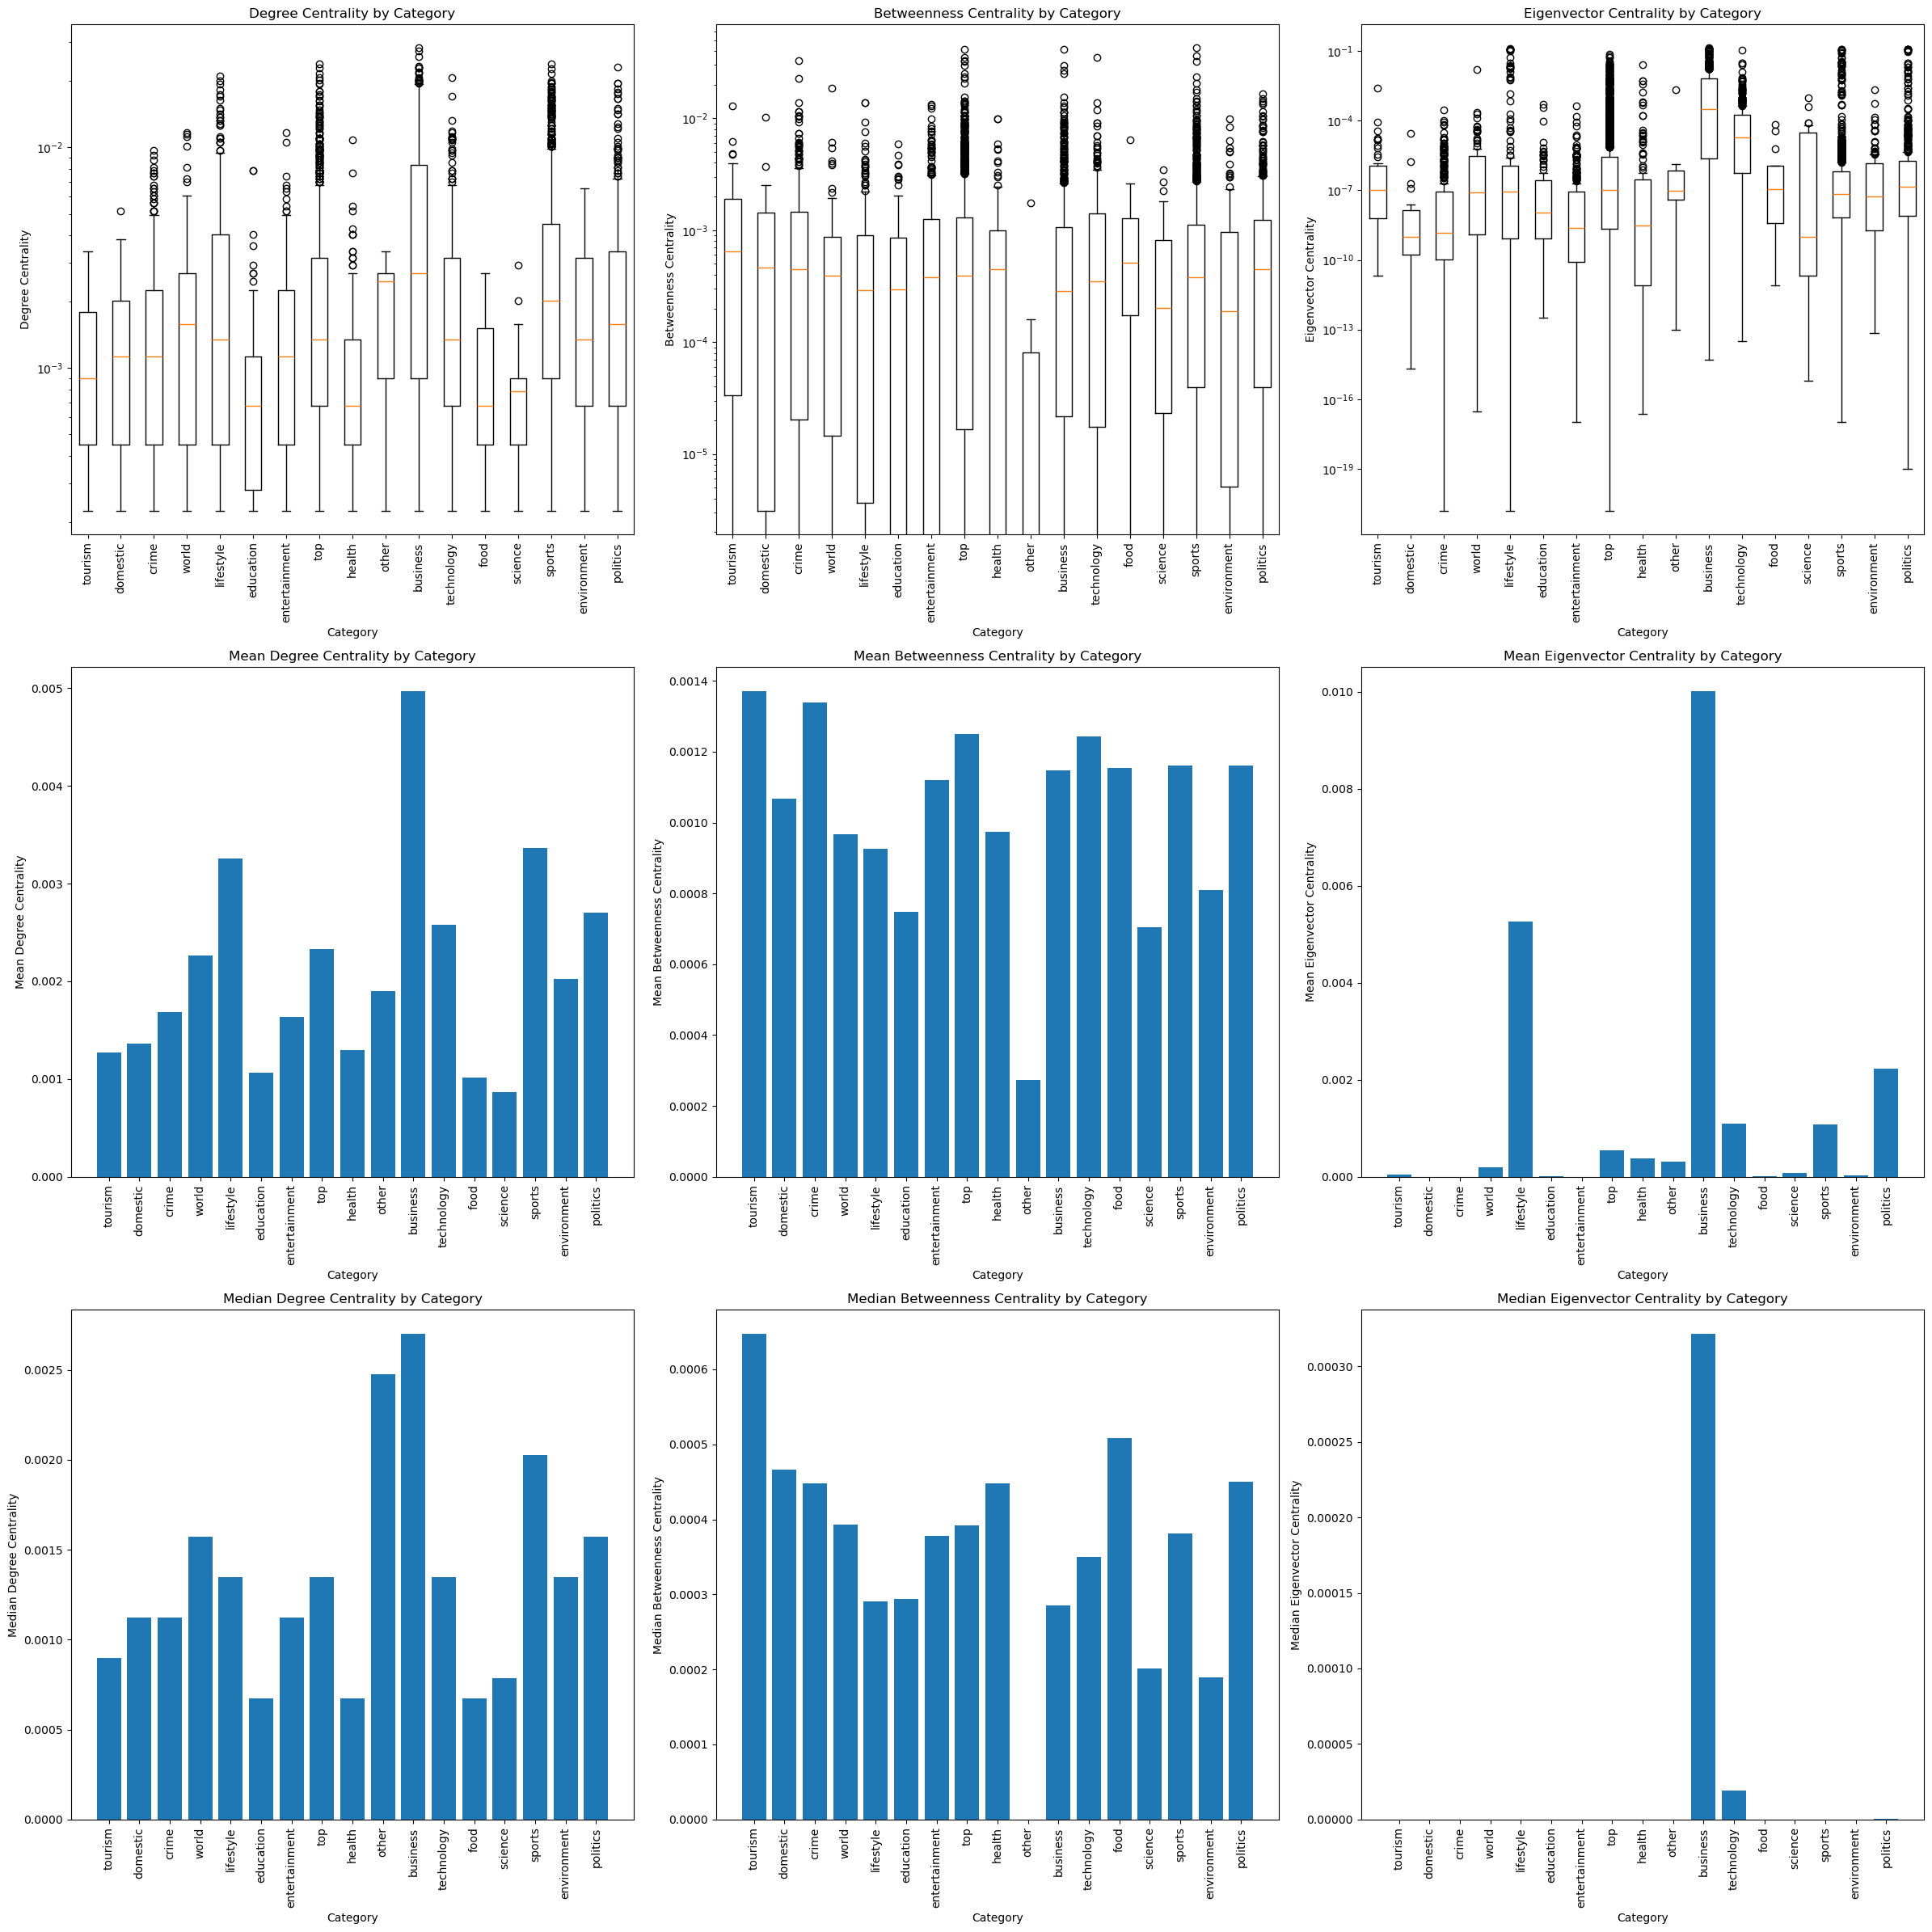

In [66]:
fig, ax = plt.subplots(3, 3, figsize=(24, 24))
ax = ax.flatten()
ax[0].boxplot([category_deg[category] for category in categories if len(category_deg[category]) > 0], labels=[category for category in categories if len(category_deg[category]) > 0], vert=True)
ax[0].set_title("Degree Centrality by Category")
ax[0].set_ylabel("Degree Centrality")
ax[0].set_xlabel("Category")
ax[0].set_yscale('log')
ax[0].tick_params(axis='x', rotation=90)

ax[1].boxplot([category_bet[category] for category in categories if len(category_bet[category]) > 0], labels=[category for category in categories if len(category_bet[category]) > 0], vert=True)
ax[1].set_title("Betweenness Centrality by Category")
ax[1].set_ylabel("Betweenness Centrality")
ax[1].set_xlabel("Category")
ax[1].set_yscale('log')
ax[1].tick_params(axis='x', rotation=90)

ax[2].boxplot([category_eigen[category] for category in categories if len(category_eigen[category]) > 0], labels=[category for category in categories if len(category_eigen[category]) > 0], vert=True)
ax[2].set_title("Eigenvector Centrality by Category")
ax[2].set_ylabel("Eigenvector Centrality")
ax[2].set_xlabel("Category")
ax[2].set_yscale('log')
ax[2].tick_params(axis='x', rotation=90)

ax[3].bar([category for category in categories if category in category_stats], [category_stats[category]['deg_mean'] for category in categories if category in category_stats])
ax[3].set_title("Mean Degree Centrality by Category")
ax[3].set_ylabel("Mean Degree Centrality")
ax[3].set_xlabel("Category")
ax[3].tick_params(axis='x', rotation=90)

ax[4].bar([category for category in categories if category in category_stats], [category_stats[category]['bet_mean'] for category in categories if category in category_stats])
ax[4].set_title("Mean Betweenness Centrality by Category")
ax[4].set_ylabel("Mean Betweenness Centrality")
ax[4].set_xlabel("Category")
ax[4].tick_params(axis='x', rotation=90)

ax[5].bar([category for category in categories if category in category_stats], [category_stats[category]['eigen_mean'] for category in categories if category in category_stats])
ax[5].set_title("Mean Eigenvector Centrality by Category")
ax[5].set_ylabel("Mean Eigenvector Centrality")
ax[5].set_xlabel("Category")
ax[5].tick_params(axis='x', rotation=90)

ax[6].bar([category for category in categories if category in category_stats], [category_stats[category]['deg_median'] for category in categories if category in category_stats])
ax[6].set_title("Median Degree Centrality by Category")
ax[6].set_ylabel("Median Degree Centrality")
ax[6].set_xlabel("Category")
ax[6].tick_params(axis='x', rotation=90)

ax[7].bar([category for category in categories if category in category_stats], [category_stats[category]['bet_median'] for category in categories if category in category_stats])
ax[7].set_title("Median Betweenness Centrality by Category")
ax[7].set_ylabel("Median Betweenness Centrality")
ax[7].set_xlabel("Category")
ax[7].tick_params(axis='x', rotation=90)

ax[8].bar([category for category in categories if category in category_stats], [category_stats[category]['eigen_median'] for category in categories if category in category_stats])
ax[8].set_title("Median Eigenvector Centrality by Category")
ax[8].set_ylabel("Median Eigenvector Centrality")
ax[8].set_xlabel("Category")
ax[8].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

In [19]:
## Use kruskal wallis test (non-parametric) to test difference in centrality between categories
from scipy.stats import kruskal
deg_data = [category_deg[category] for category in categories if len(category_deg[category]) > 0]
bet_data = [category_bet[category] for category in categories if len(category_bet[category]) > 0]
eigen_data = [category_eigen[category] for category in categories if len(category_eigen[category]) > 0]
deg_stat, deg_p = kruskal(*deg_data)
bet_stat, bet_p = kruskal(*bet_data)
eigen_stat, eigen_p = kruskal(*eigen_data)
print("Kruskal-Wallis test for Degree Centrality across categories: stat =", deg_stat, ", p-value =", deg_p)
print("Kruskal-Wallis test for Betweenness Centrality across categories: stat =", bet_stat, ", p-value =", bet_p)
print("Kruskal-Wallis test for Eigenvector Centrality across categories: stat =", eigen_stat, ", p-value =", eigen_p)

Kruskal-Wallis test for Degree Centrality across categories: stat = 414.8225571819382 , p-value = 2.8356822460670926e-78
Kruskal-Wallis test for Betweenness Centrality across categories: stat = 28.392551648448432 , p-value = 0.028368953380763534
Kruskal-Wallis test for Eigenvector Centrality across categories: stat = 1474.086804645925 , p-value = 1.906676642154571e-304


The correlation between the centrality measures is moderate to strong for degree- and eigenvector-centrality ($\rho=0.65$), and moderate for degree and betweenness ($\rho=0.56$), while betweenness and eigenvector only correlate weakly ($\rho=0.30$). It suggests that degree and eigenvector mostly describe the same type of 'popularity', while betweenness to a greater extent catches bridge-roles between communities.

Kruskal-Wallis-tests shows that both degree, betweenness and eigenvector centrality varies significantly across news categoreis ($p-value<0.029$ for all). The differences are especially significant fir eigenvector centrality ($H\approx1474$, p-value $\approx 10^{-304}$). Business-articles have on average $2.4$ times higher degree- and $8$ times higher eigenvector-centrality than the mean of all articles, while sports-, lifestyle-, politics- and technology articles also is above the mean. This indicates that the networks cores is dominated by business-news, while bridge-nodes with high betweeness exists across multiple categories.

In [ ]:
sources = set(nwdf['source_name'])
source_deg = {source: [] for source in sources}
source_bet = {source: [] for source in sources}
source_eigen = {source: [] for source in sources}

for article, centrality in deg_centrality:
    if article in nwdf['article id'].values:
        article_sources = nwdf[nwdf['article id'] == article]['source_name'].values[0]
        if isinstance(article_sources, list):
            for source in article_sources:
                source_deg[source].append(centrality)
        else:
            source_deg[article_sources].append(centrality)

for article, centrality in bet_centrality:
    if article in nwdf['article id'].values:
        article_sources = nwdf[nwdf['article id'] == article]['source_name'].values[0]
        if isinstance(article_sources, list):
            for source in article_sources:
                source_bet[source].append(centrality)
        else:
            source_bet[article_sources].append(centrality)

for article, centrality in eigen_centrality:
    if article in nwdf['article id'].values:
        article_sources = nwdf[nwdf['article id'] == article]['source_name'].values[0]
        if isinstance(article_sources, list):
            for source in article_sources:
                source_eigen[source].append(centrality)
        else:
            source_eigen[article_sources].append(centrality)

source_stats = {}
for source in sources:
    deg_values = source_deg[source]
    bet_values = source_bet[source]
    eigen_values = source_eigen[source]
    if len(deg_values) > 0:
        source_stats[source] = {
            'deg_mean': statistics.mean(deg_values),
            'deg_median': statistics.median(deg_values),
            'deg_std': statistics.stdev(deg_values) if len(deg_values) > 1 else 0,
            'bet_mean': statistics.mean(bet_values) if len(bet_values) > 0 else 0,
            'bet_median': statistics.median(bet_values) if len(bet_values) > 0 else 0,
            'bet_std': statistics.stdev(bet_values) if len(bet_values) > 1 else 0,
            'eigen_mean': statistics.mean(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_median': statistics.median(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_std': statistics.stdev(eigen_values) if len(eigen_values) > 1 else 0,
        }
deg_data = [source_deg[source] for source in sources if len(source_deg[source]) > 0]
bet_data = [source_bet[source] for source in sources if len(source_bet[source]) > 0]
eigen_data = [source_eigen[source] for source in sources if len(source_eigen[source]) > 0]
deg_stat, deg_p = kruskal(*deg_data)
bet_stat, bet_p = kruskal(*bet_data)
eigen_stat, eigen_p = kruskal(*eigen_data)
print("Kruskal-Wallis test for Degree Centrality across sources: stat =", deg_stat, ", p-value =", deg_p)
print("Kruskal-Wallis test for Betweenness Centrality across sources: stat =", bet_stat, ", p-value =", bet_p)
print("Kruskal-Wallis test for Eigenvector Centrality across sources: stat =", eigen_stat, ", p-value =", eigen_p)

Kruskal-Wallis test for Degree Centrality across sources: stat = 1869.0503297645257 , p-value = 1.1915184739863202e-74
Kruskal-Wallis test for Betweenness Centrality across sources: stat = 1164.264281309245 , p-value = 1.0316958744389658e-10
Kruskal-Wallis test for Eigenvector Centrality across sources: stat = 2359.618738061675 , p-value = 3.2339613821354877e-137
{'Hiiraan': {'deg_mean': 0.0006749156355455568, 'deg_median': 0.0006749156355455568, 'deg_std': 0, 'bet_mean': 0.00012120114234500264, 'bet_median': 0.00012120114234500264, 'bet_std': 0, 'eigen_mean': 4.838158268722649e-09, 'eigen_median': 4.838158268722649e-09, 'eigen_std': 0}, 'Afaqs': {'deg_mean': 0.003037120359955006, 'deg_median': 0.003037120359955006, 'deg_std': 0.0039769785218590975, 'bet_mean': 0.0007245929559432755, 'bet_median': 0.0007245929559432755, 'bet_std': 0.0010247291854949907, 'eigen_mean': 0.0003063854740663598, 'eigen_median': 0.0003063854740663598, 'eigen_std': 0.0004332944909013253}, 'Premium Times': {'de

In [21]:
countries = set(nwdf['country'])
country_deg = {country: [] for country in countries}
country_bet = {country: [] for country in countries}
country_eigen = {country: [] for country in countries}

for article, centrality in deg_centrality:
    if article in nwdf['article id'].values:
        article_countries = nwdf[nwdf['article id'] == article]['country'].values[0]
        if isinstance(article_countries, list):
            for country in article_countries:
                country_deg[country].append(centrality)
        else:
            country_deg[article_countries].append(centrality)

for article, centrality in bet_centrality:
    if article in nwdf['article id'].values:
        article_countries = nwdf[nwdf['article id'] == article]['country'].values[0]
        if isinstance(article_countries, list):
            for country in article_countries:
                country_bet[country].append(centrality)
        else:
            country_bet[article_countries].append(centrality)

for article, centrality in eigen_centrality:
    if article in nwdf['article id'].values:
        article_countries = nwdf[nwdf['article id'] == article]['country'].values[0]
        if isinstance(article_countries, list):
            for country in article_countries:
                country_eigen[country].append(centrality)
        else:
            country_eigen[article_countries].append(centrality)

country_stats = {}
for country in countries:
    deg_values = country_deg[country]
    bet_values = country_bet[country]
    eigen_values = country_eigen[country]
    if len(deg_values) > 0:
        country_stats[country] = {
            'deg_mean': statistics.mean(deg_values),
            'deg_median': statistics.median(deg_values),
            'deg_std': statistics.stdev(deg_values) if len(deg_values) > 1 else 0,
            'bet_mean': statistics.mean(bet_values) if len(bet_values) > 0 else 0,
            'bet_median': statistics.median(bet_values) if len(bet_values) > 0 else 0,
            'bet_std': statistics.stdev(bet_values) if len(bet_values) > 1 else 0,
            'eigen_mean': statistics.mean(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_median': statistics.median(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_std': statistics.stdev(eigen_values) if len(eigen_values) > 1 else 0,
        }
deg_data = [country_deg[country] for country in countries if len(country_deg[country]) > 0]
bet_data = [country_bet[country] for country in countries if len(country_bet[country]) > 0]
eigen_data = [country_eigen[country] for country in countries if len(country_eigen[country]) > 0]
deg_stat, deg_p = kruskal(*deg_data)
bet_stat, bet_p = kruskal(*bet_data)
eigen_stat, eigen_p = kruskal(*eigen_data)
print("Kruskal-Wallis test for Degree Centrality across countries: stat =", deg_stat, ", p-value =", deg_p)
print("Kruskal-Wallis test for Betweenness Centrality across countries: stat =", bet_stat, ", p-value =", bet_p)
print("Kruskal-Wallis test for Eigenvector Centrality across countries: stat =", eigen_stat, ", p-value =", eigen_p)


Kruskal-Wallis test for Degree Centrality across countries: stat = 414.1341758091028 , p-value = 6.914302336772016e-52
Kruskal-Wallis test for Betweenness Centrality across countries: stat = 155.2700322313414 , p-value = 3.7134939801257676e-09
Kruskal-Wallis test for Eigenvector Centrality across countries: stat = 436.5280882096335 , p-value = 5.0681136972133555e-56


In [22]:
communities = set(nwdf['louvain_community'])
community_deg = {community: [] for community in communities}
community_bet = {community: [] for community in communities}
community_eigen = {community: [] for community in communities}

for article, centrality in deg_centrality:
    if article in nwdf['article id'].values:
        article_communities = nwdf[nwdf['article id'] == article]['louvain_community'].values[0]
        if isinstance(article_communities, list):
            for community in article_communities:
                community_deg[community].append(centrality)
        else:
            community_deg[article_communities].append(centrality)

for article, centrality in bet_centrality:
    if article in nwdf['article id'].values:
        article_communities = nwdf[nwdf['article id'] == article]['louvain_community'].values[0]
        if isinstance(article_communities, list):
            for community in article_communities:
                community_bet[community].append(centrality)
        else:
            community_bet[article_communities].append(centrality)

for article, centrality in eigen_centrality:
    if article in nwdf['article id'].values:
        article_communities = nwdf[nwdf['article id'] == article]['louvain_community'].values[0]
        if isinstance(article_communities, list):
            for community in article_communities:
                community_eigen[community].append(centrality)
        else:
            community_eigen[article_communities].append(centrality)

community_stats = {}
for community in communities:
    deg_values = community_deg[community]
    bet_values = community_bet[community]
    eigen_values = community_eigen[community]
    if len(deg_values) > 0:
        community_stats[community] = {
            'deg_mean': statistics.mean(deg_values),
            'deg_median': statistics.median(deg_values),
            'deg_std': statistics.stdev(deg_values) if len(deg_values) > 1 else 0,
            'bet_mean': statistics.mean(bet_values) if len(bet_values) > 0 else 0,
            'bet_median': statistics.median(bet_values) if len(bet_values) > 0 else 0,
            'bet_std': statistics.stdev(bet_values) if len(bet_values) > 1 else 0,
            'eigen_mean': statistics.mean(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_median': statistics.median(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_std': statistics.stdev(eigen_values) if len(eigen_values) > 1 else 0,
        }
deg_data = [community_deg[community] for community in communities if len(community_deg[community]) > 0]
bet_data = [community_bet[community] for community in communities if len(community_bet[community]) > 0]
eigen_data = [community_eigen[community] for community in communities if len(community_eigen[community]) > 0]
deg_stat, deg_p = kruskal(*deg_data)
bet_stat, bet_p = kruskal(*bet_data)
eigen_stat, eigen_p = kruskal(*eigen_data)
print("Kruskal-Wallis test for Degree Centrality across communities: stat =", deg_stat, ", p-value =", deg_p)
print("Kruskal-Wallis test for Betweenness Centrality across communities: stat =", bet_stat, ", p-value =", bet_p)
print("Kruskal-Wallis test for Eigenvector Centrality across communities: stat =", eigen_stat, ", p-value =", eigen_p)

Kruskal-Wallis test for Degree Centrality across communities: stat = 989.0096477272597 , p-value = 1.815993334363433e-189
Kruskal-Wallis test for Betweenness Centrality across communities: stat = 103.8662556693595 , p-value = 2.332367830868092e-10
Kruskal-Wallis test for Eigenvector Centrality across communities: stat = 2726.0341897579983 , p-value = 0.0


In [42]:
dates = ([nwdf['publication_date'][article][8:10] for article in range(len(nwdf['publication_date']))])
count_of_dates_percent = pd.Series(dates).value_counts(normalize=True).sort_index() * 100
count_of_dates_percent

04    12.201444
09    15.349009
11    42.029254
12    30.420293
Name: proportion, dtype: float64

C:\Users\Nicolai\AppData\Local\Temp\ipykernel_8856\1756576479.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot([community_deg[category] for category in communities if len(community_deg[category]) > 0], labels=[category for category in communities if len(community_deg[category]) > 0], vert=True)
C:\Users\Nicolai\AppData\Local\Temp\ipykernel_8856\1756576479.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot([community_bet[category] for category in communities if len(community_bet[category]) > 0], labels=[category for category in communities if len(community_bet[category]) > 0], vert=True)
C:\Users\Nicolai\AppData\Local\Temp\ipykernel_8856\1756576479.py:17: MatplotlibDeprecationWarning: The 'labels' parameter o

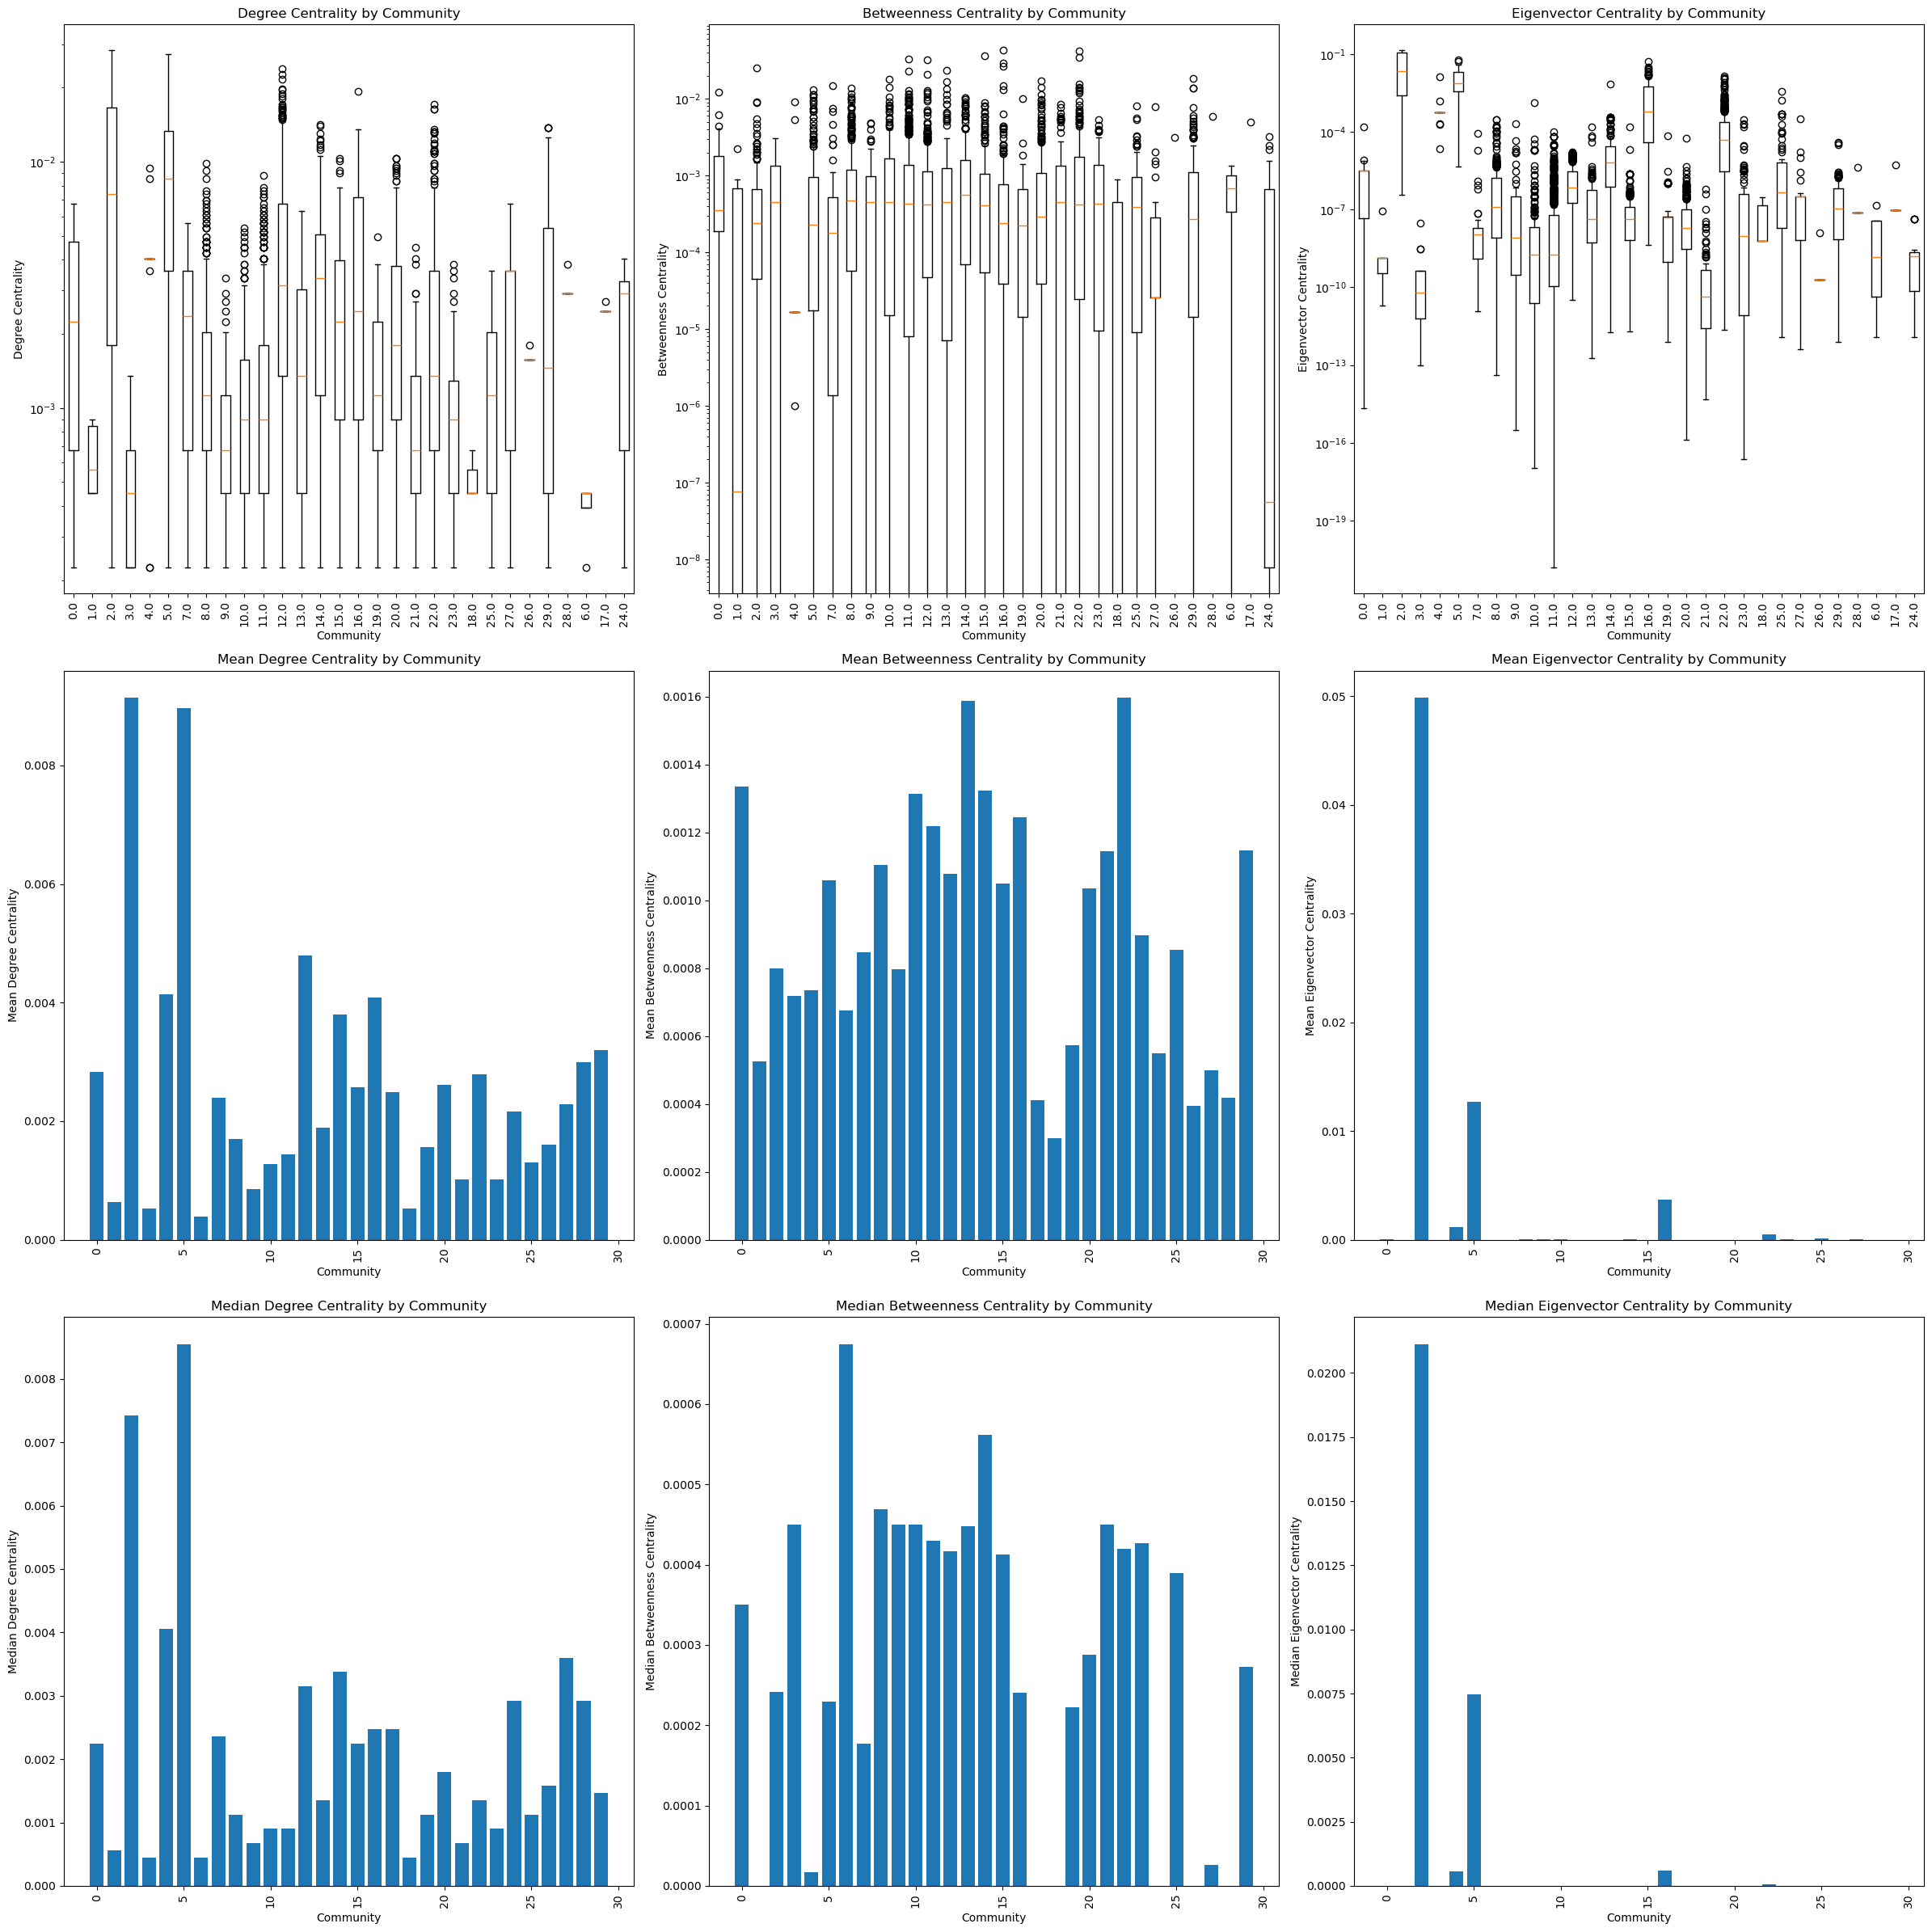

In [65]:
fig, ax = plt.subplots(3, 3, figsize=(24, 24))
ax = ax.flatten()
ax[0].boxplot([community_deg[category] for category in communities if len(community_deg[category]) > 0], labels=[category for category in communities if len(community_deg[category]) > 0], vert=True)
ax[0].set_title("Degree Centrality by Community")
ax[0].set_ylabel("Degree Centrality")
ax[0].set_xlabel("Community")
ax[0].set_yscale('log')
ax[0].tick_params(axis='x', rotation=90)

ax[1].boxplot([community_bet[category] for category in communities if len(community_bet[category]) > 0], labels=[category for category in communities if len(community_bet[category]) > 0], vert=True)
ax[1].set_title("Betweenness Centrality by Community")
ax[1].set_ylabel("Betweenness Centrality")
ax[1].set_xlabel("Community")
ax[1].set_yscale('log')
ax[1].tick_params(axis='x', rotation=90)

ax[2].boxplot([community_eigen[category] for category in communities if len(community_eigen[category]) > 0], labels=[category for category in communities if len(community_eigen[category]) > 0], vert=True)
ax[2].set_title("Eigenvector Centrality by Community")
ax[2].set_ylabel("Eigenvector Centrality")
ax[2].set_xlabel("Community")
ax[2].set_yscale('log')
ax[2].tick_params(axis='x', rotation=90)

ax[3].bar([category for category in communities if category in community_stats], [community_stats[category]['deg_mean'] for category in communities if category in community_stats])
ax[3].set_title("Mean Degree Centrality by Community")
ax[3].set_ylabel("Mean Degree Centrality")
ax[3].set_xlabel("Community")
ax[3].tick_params(axis='x', rotation=90)

ax[4].bar([category for category in communities if category in community_stats], [community_stats[category]['bet_mean'] for category in communities if category in community_stats])
ax[4].set_title("Mean Betweenness Centrality by Community")
ax[4].set_ylabel("Mean Betweenness Centrality")
ax[4].set_xlabel("Community")
ax[4].tick_params(axis='x', rotation=90)

ax[5].bar([category for category in communities if category in community_stats], [community_stats[category]['eigen_mean'] for category in communities if category in community_stats])
ax[5].set_title("Mean Eigenvector Centrality by Community")
ax[5].set_ylabel("Mean Eigenvector Centrality")
ax[5].set_xlabel("Community")
ax[5].tick_params(axis='x', rotation=90)

ax[6].bar([category for category in communities if category in community_stats], [community_stats[category]['deg_median'] for category in communities if category in community_stats])
ax[6].set_title("Median Degree Centrality by Community")
ax[6].set_ylabel("Median Degree Centrality")
ax[6].set_xlabel("Community")
ax[6].tick_params(axis='x', rotation=90)

ax[7].bar([category for category in communities if category in community_stats], [community_stats[category]['bet_median'] for category in communities if category in community_stats])
ax[7].set_title("Median Betweenness Centrality by Community")
ax[7].set_ylabel("Median Betweenness Centrality")
ax[7].set_xlabel("Community")
ax[7].tick_params(axis='x', rotation=90)

ax[8].bar([category for category in communities if category in community_stats], [community_stats[category]['eigen_median'] for category in communities if category in community_stats])
ax[8].set_title("Median Eigenvector Centrality by Community")
ax[8].set_ylabel("Median Eigenvector Centrality")
ax[8].set_xlabel("Community")
ax[8].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()